In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import math
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
from scipy.stats import norm
from dataclasses import dataclass
from typing import List, Dict, Any, Union


In [63]:
# ================================================
# Clases auxiliares y funciones de generación de datos
# ================================================

@dataclass
class StochasticPrice:
    """
    A class representing a price with stochastic variation.
    Used for simulating real-world price fluctuations in travel planning.
    """
    base_price: float
    std_dev: float = None
    
    def __post_init__(self):
        if self.std_dev is None:
            self.std_dev = self.base_price * 0.2
    
    def sample(self) -> float:
        """
        Generate a random price sample based on normal distribution.

        Returns:
            float: A random price value, minimum 1.0
        """
        return max(1.0, norm.rvs(loc=self.base_price, scale=self.std_dev))

@dataclass
class Place:
    """
    A class representing a tourist destination or venue with its attributes.
    Includes name, location, cost, rating and other relevant information.
    """
    name: str
    city: str
    cost: Union[float, StochasticPrice]
    final_cost: float
    rating: float
    type: str
    description: str = ""
    
    def get_cost(self) -> float:
        """
        Calculate the final cost of the place, either static or stochastic.

        Returns:
            float: The final calculated cost
        """
        if isinstance(self.cost, StochasticPrice):
            self.final_cost = self.cost.sample()
        else:
            self.final_cost = self.cost
            
        return self.final_cost


def generate_test_places(num_gastronomicos=15, num_nocturnos=10, num_alojamientos=8):
    places = {
        "gastronomicos": [
            Place(
                name=f"Restaurante {i}",
                city="TestCity",
                cost=StochasticPrice(base_price=random.uniform(10, 30)),
                final_cost=0.0,
                rating=random.uniform(7, 10),
                type="restaurant"
            ) for i in range(num_gastronomicos)
        ],
        "nocturnos": [
            Place(
                name=f"Club {i}",
                city="TestCity",
                cost=StochasticPrice(base_price=random.uniform(15, 40)),
                final_cost=0.0,
                rating=random.uniform(7, 10),
                type="nightlife"
            ) for i in range(num_nocturnos)
        ],
        "alojamientos": [
            Place(
                name=f"Hotel {i}",
                city="TestCity",
                cost=StochasticPrice(base_price=random.uniform(40, 100)),
                final_cost=0.0,
                rating=random.uniform(7, 10),
                type="lodging"
            ) for i in range(num_alojamientos)
        ]
    }
    return places


In [64]:
# ================================================
# Clase TravelPlanner con algoritmo modificado para seguimiento
# ================================================

class TravelPlanner:
    def get_price_means(self, sol, n):
        means = []
        for day in sol:
            day_costs = { key: 0 for key in day }
            for _ in range(n):
                day_costs["desayuno"] += day["desayuno"].get_cost()
                day_costs["almuerzo"] += day["almuerzo"].get_cost()
                day_costs["cena"] += day["cena"].get_cost()
                day_costs["noche"] += day["noche"].get_cost()
                day_costs["alojamiento"] += day["alojamiento"].get_cost()
            
            day_costs = { key: day_costs[key] / 30 for key in day_costs }
            means.append(sum(day_costs.values()))
        
        return means

    def evaluate(self, sol, n=30):
        ratings = [
            day["desayuno"].rating +
            day["almuerzo"].rating +
            day["cena"].rating +
            day["noche"].rating +
            day["alojamiento"].rating
            for day in sol
        ]
        
        price_means = self.get_price_means(sol, n)
        
        return sum([ratings[i] / price_means[i] for i in range(len(sol))])
    
    def is_valid_solution(self, sol, budget_per_day):
        for day in sol:
            total_cost = (
                day["desayuno"].get_cost() +
                day["almuerzo"].get_cost() +
                day["cena"].get_cost() +
                day["noche"].get_cost() +
                day["alojamiento"].get_cost()
            )
            if total_cost > budget_per_day:
                return False
        return True

    def simulated_annealing_with_history(
        self, days, places, budget_per_day, destination, 
        max_iter=1000, max_time=180, T=100.0, alpha=0.99, T_min=0.1
    ):
        """Versión modificada del algoritmo que registra el historial de convergencia"""
        
        def generate_initial_solution():
            solution = []
            for _ in range(days):
                day = {
                    "desayuno": random.choice(places["gastronomicos"]),
                    "almuerzo": random.choice(places["gastronomicos"]),
                    "cena": random.choice(places["gastronomicos"]),
                    "noche": random.choice(places["nocturnos"]),
                    "alojamiento": random.choice(places["alojamientos"])
                }
                solution.append(day)
            return solution
        
        def generate_neighbor(sol):
            day_idx = random.randint(0, len(sol)-1)
            activity = random.choice(["desayuno", "almuerzo", "cena", "noche", "alojamiento"])
            
            new_sol = [d.copy() for d in sol]
            if activity in ["desayuno", "almuerzo", "cena"]:
                new_sol[day_idx][activity] = random.choice(places["gastronomicos"])
            elif activity == "noche":
                new_sol[day_idx][activity] = random.choice(places["nocturnos"])
            else:
                new_sol[day_idx][activity] = random.choice(places["alojamientos"])
            
            return new_sol

        # Historial de convergencia
        convergence_history = []
        
        # Generar solución inicial válida
        current_sol = generate_initial_solution()
        while not self.is_valid_solution(current_sol, budget_per_day):
            current_sol = generate_initial_solution()
        
        best_sol = current_sol.copy()
        best_rating = self.evaluate(current_sol)
        current_rating = best_rating
        
        # Registro inicial
        convergence_history.append({
            'iteration': 0,
            'temperature': T,
            'current_rating': current_rating,
            'best_rating': best_rating,
            'time': 0
        })
        
        start_time = time.time()
        iter_count = 0
        
        # Bucle principal de recocido simulado
        while T > T_min and (time.time() - start_time) < max_time:
            for _ in range(max_iter):
                iter_count += 1
                elapsed_time = time.time() - start_time
                
                # Comprobar tiempo máximo
                if elapsed_time > max_time:
                    break
                
                # Generar vecino
                neighbor_sol = generate_neighbor(current_sol)
                if not self.is_valid_solution(neighbor_sol, budget_per_day):
                    continue
                    
                neighbor_rating = self.evaluate(neighbor_sol)
                current_rating = self.evaluate(current_sol)
                delta = neighbor_rating - current_rating
                
                # Criterio de aceptación
                if delta > 0 or random.random() < math.exp(delta / T):
                    current_sol = neighbor_sol
                    current_rating = neighbor_rating
                    
                    # Actualizar mejor solución
                    if neighbor_rating > best_rating:
                        best_sol = neighbor_sol.copy()
                        best_rating = neighbor_rating
                
                # Registrar cada 50 iteraciones
                if iter_count % 20 == 0:
                    convergence_history.append({
                        'iteration': iter_count,
                        'temperature': T,
                        'current_rating': current_rating,
                        'best_rating': best_rating,
                        'time': elapsed_time
                    })
            
            # Enfriamiento
            T *= alpha
        
        return best_sol, pd.DataFrame(convergence_history)

In [65]:
# ================================================
# Configuración de experimentos
# ================================================

# Parámetros base
DAYS = 3
BUDGET_PER_DAY = 150
DESTINATION = "TestCity"
MAX_ITER = 1000
MAX_TIME = 60  # 60 segundos para acelerar experimentos
T_MIN = 0.1
NUM_RUNS = 30  # Número de ejecuciones por configuración

# Combinaciones de parámetros a evaluar
param_combinations = [
    {'T': 100, 'alpha': 0.95},
    {'T': 100, 'alpha': 0.99},
    {'T': 200, 'alpha': 0.95},
    {'T': 200, 'alpha': 0.99},
]

In [66]:
# ================================================
# Ejecución de experimentos
# ================================================

results = []
planner = TravelPlanner()

for params in tqdm(param_combinations, desc="Combinaciones de parámetros"):
    T_val = params['T']
    alpha_val = params['alpha']
    
    for run in range(NUM_RUNS):
        # Generar nuevos lugares para cada ejecución
        places = generate_test_places()
        
        # Ejecutar algoritmo
        start_time = time.time()
        best_sol, history_df = planner.simulated_annealing_with_history(
            days=DAYS,
            places=places,
            budget_per_day=BUDGET_PER_DAY,
            destination=DESTINATION,
            max_iter=MAX_ITER,
            max_time=MAX_TIME,
            T=T_val,
            alpha=alpha_val,
            T_min=T_MIN
        )
        exec_time = time.time() - start_time
        
        # Calcular métricas
        final_rating = history_df['best_rating'].iloc[-1]
        improvement = final_rating - history_df['best_rating'].iloc[0]
        convergence_iter = history_df.loc[history_df['best_rating'] >= 0.99 * final_rating, 'iteration'].min()
        
        # Almacenar resultados
        results.append({
            'T': T_val,
            'alpha': alpha_val,
            'run': run,
            'final_rating': final_rating,
            'initial_rating': history_df['best_rating'].iloc[0],
            'improvement': improvement,
            'convergence_iter': convergence_iter,
            'execution_time': exec_time,
            'history': history_df
        })

# Convertir a DataFrame
results_df = pd.DataFrame(results)

Combinaciones de parámetros: 100%|██████████| 4/4 [2:48:52<00:00, 2533.15s/it]  


In [74]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
results_df.to_csv(f"resultados_completos_{timestamp}.csv", index=False)

In [77]:
# ================================================
# Análisis de convergencia
# ================================================

# 1. Evolución típica de la solución
def plot_convergence_example():
    example_run = results_df.iloc[0]['history']
    plt.figure(figsize=(12, 6))
    plt.plot(example_run['iteration'], example_run['best_rating'], 'b-', label='Mejor solución')
    plt.plot(example_run['iteration'], example_run['current_rating'], 'r--', alpha=0.5, label='Solución actual')
    plt.title('Evolución de la solución durante la optimización')
    plt.xlabel('Iteración')
    plt.ylabel('Puntuación')
    plt.legend()
    plt.grid(True)
    
    # Guardar las gráfica
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.gcf().savefig(f'convergence_example_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 2. Comparación de parámetros
def plot_parameter_comparison():
    # Agrupar por combinación de parámetros
    grouped = results_df.groupby(['T', 'alpha'])
    
    # Calcular estadísticas
    stats_df = grouped.agg({
        'final_rating': ['mean', 'std'],
        'improvement': 'mean',
        'convergence_iter': 'mean',
        'execution_time': 'mean'
    }).reset_index()
    stats_df.columns = ['T', 'alpha', 'avg_rating', 'std_rating', 
                       'avg_improvement', 'avg_convergence_iter', 'avg_execution_time']
    
    # Gráfica de calidad de solución
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(data=stats_df, x='T', y='avg_rating', hue='alpha')
    plt.title('Puntuación Promedio por Combinación de Parámetros')
    plt.ylabel('Puntuación promedio')
    plt.ylim(stats_df['avg_rating'].min() - 5, stats_df['avg_rating'].max() + 5)
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=stats_df, x='T', y='avg_improvement', hue='alpha')
    plt.title('Mejora Promedio por Combinación de Parámetros')
    plt.ylabel('Mejora promedio')
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=stats_df, x='T', y='avg_convergence_iter', hue='alpha')
    plt.title('Iteración Promedio de Convergencia (99%)')
    plt.ylabel('Iteración de convergencia')
    
    plt.subplot(2, 2, 4)
    sns.barplot(data=stats_df, x='T', y='avg_execution_time', hue='alpha')
    plt.title('Tiempo de Ejecución Promedio')
    plt.ylabel('Tiempo (s)')
    
    plt.tight_layout()
    
    # Guardar las gráfica
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.gcf().savefig(f'parameter_comparison_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return stats_df

# 3. Curvas de convergencia promedio
def plot_avg_convergence():
    plt.figure(figsize=(14, 8))
    
    # Combinaciones únicas de parámetros
    param_sets = results_df[['T', 'alpha']].drop_duplicates().values
    
    for T_val, alpha_val in param_sets:
        # Filtrar ejecuciones para esta combinación
        subset = results_df[(results_df['T'] == T_val) & (results_df['alpha'] == alpha_val)]
        
        # Encontrar máxima longitud de iteraciones
        max_iter = max(df['iteration'].max() for df in subset['history'])
        iterations = np.arange(0, max_iter + 1, 50)
        
        # Inicializar matriz para almacenar curvas
        ratings_matrix = np.full((len(subset), len(iterations)), np.nan)
        
        # Llenar matriz con datos de cada ejecución
        for i, row in enumerate(subset.itertuples()):
            df = row.history
            for idx, iter_val in enumerate(iterations):
                if iter_val in df['iteration'].values:
                    ratings_matrix[i, idx] = df.loc[df['iteration'] == iter_val, 'best_rating'].values[0]
                elif idx > 0:
                    ratings_matrix[i, idx] = ratings_matrix[i, idx-1]
        
        # Calcular promedio y desviación estándar
        avg_ratings = np.nanmean(ratings_matrix, axis=0)
        std_ratings = np.nanstd(ratings_matrix, axis=0)
        
        # Graficar
        plt.plot(iterations, avg_ratings, label=f'T={T_val}, α={alpha_val}')
        plt.fill_between(iterations, avg_ratings - std_ratings, avg_ratings + std_ratings, alpha=0.2)
    
    plt.title('Convergencia Promedio por Combinación de Parámetros')
    plt.xlabel('Iteración')
    plt.ylabel('Puntuación Promedio')
    plt.legend()
    plt.grid(True)
    
    # Guardar las gráfica
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.gcf().savefig(f'avg_convergence_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

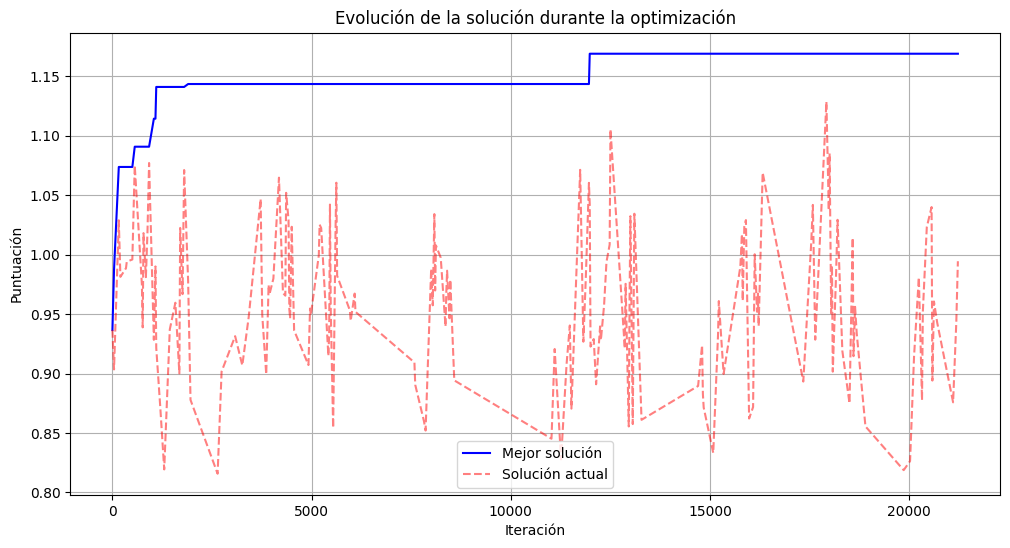

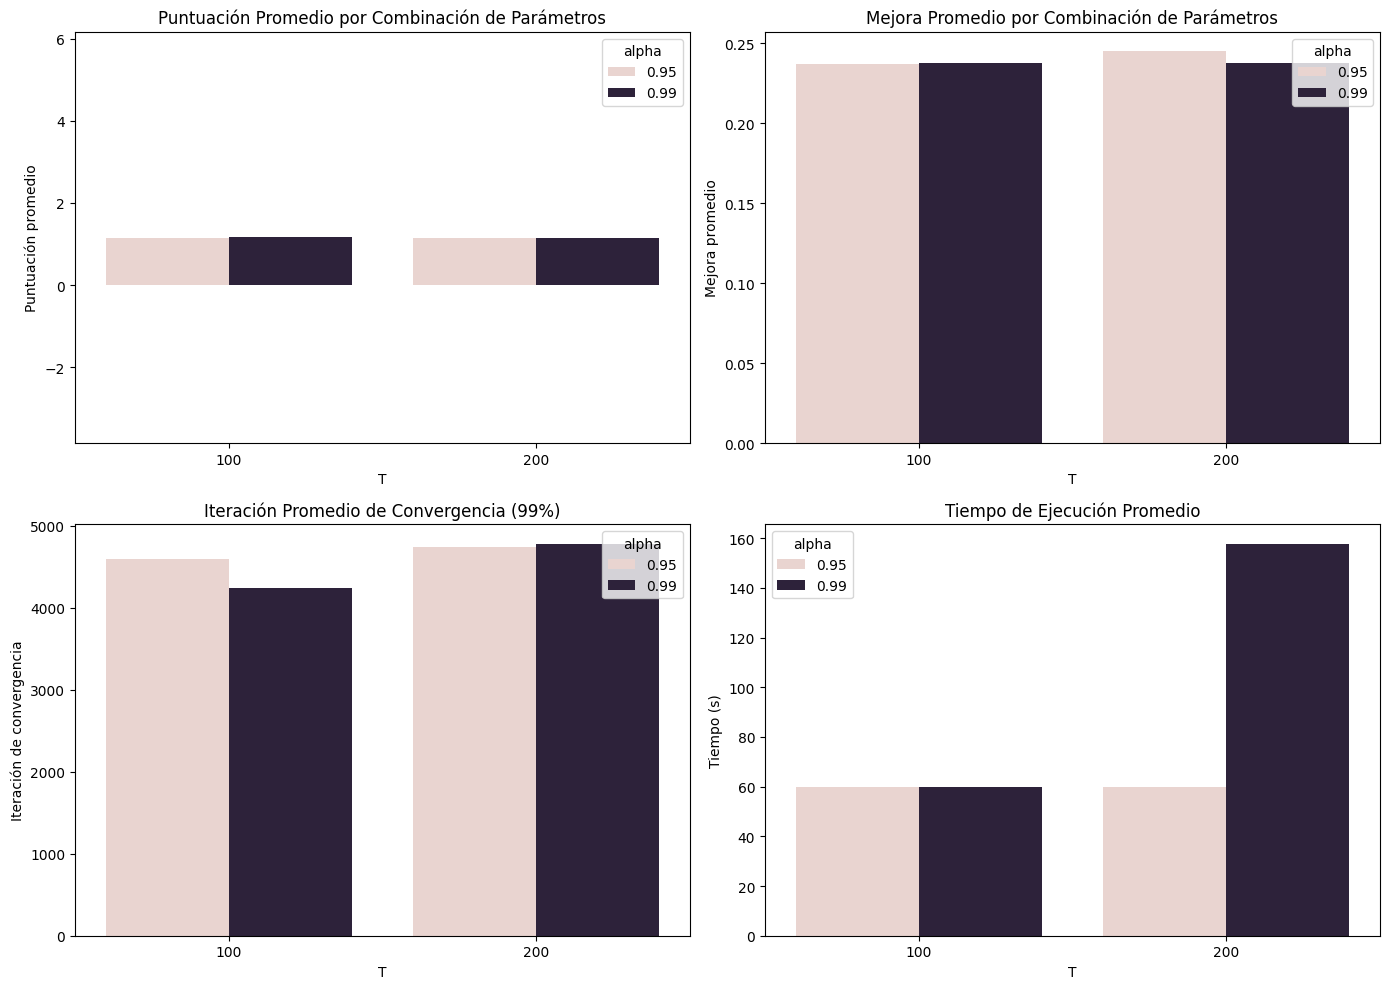

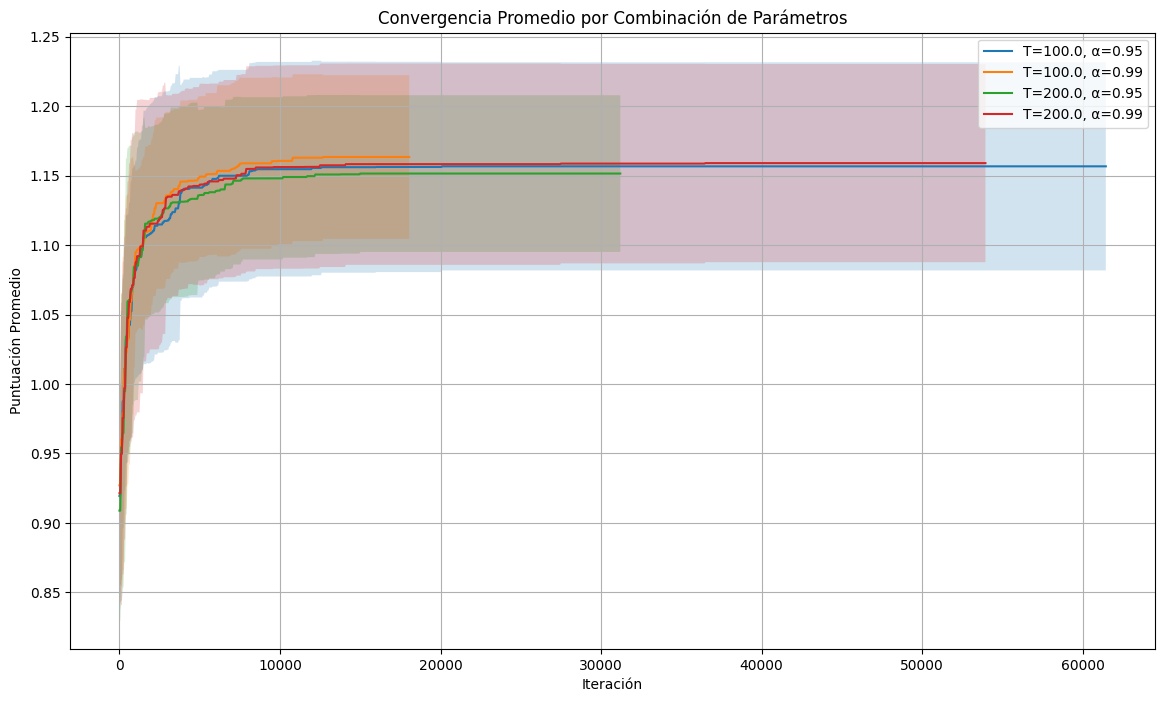


Mejor combinación de parámetros:
Temperatura inicial (T): 100.0
Factor de enfriamiento (α): 0.99
Puntuación promedio: 1.16
Iteración promedio de convergencia: 4239
Tiempo promedio: 60.02s


In [78]:
# ================================================
# Ejecutar análisis
# ================================================

# 1. Ejemplo de convergencia individual
plot_convergence_example()

# 2. Comparación de parámetros
stats_df = plot_parameter_comparison()

# 3. Curvas de convergencia promedio
plot_avg_convergence()

# 4. Mostrar mejores parámetros
best_params = stats_df.loc[stats_df['avg_rating'].idxmax()]
print("\nMejor combinación de parámetros:")
print(f"Temperatura inicial (T): {best_params['T']}")
print(f"Factor de enfriamiento (α): {best_params['alpha']}")
print(f"Puntuación promedio: {best_params['avg_rating']:.2f}")
print(f"Iteración promedio de convergencia: {best_params['avg_convergence_iter']:.0f}")
print(f"Tiempo promedio: {best_params['avg_execution_time']:.2f}s")